<h1 style="font-family: Trebuchet MS; padding: 30px; font-size: 30px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000"><b>Project "FRANCHISE" By Mochamad Riki Dharmawan</b></h1>

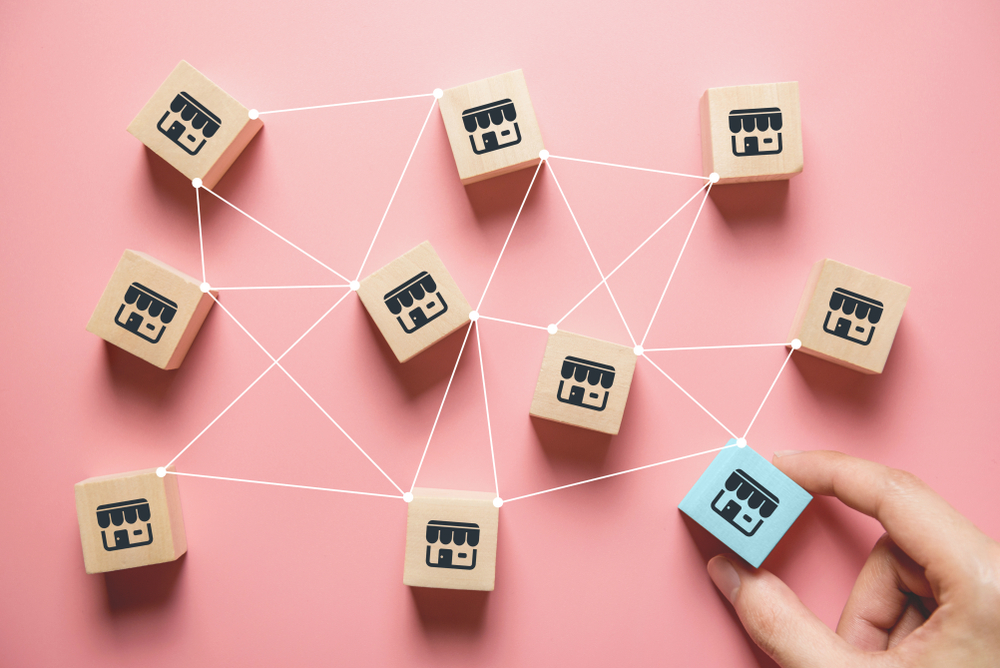

<a class="anchor" id="-1">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Background of the Project 🔙</h1></center>

**Tentang dataset:**

Dataset ini merupakan dataset yang berisi 524 nama Franchise dengan kategori makanan & minuman yang ada di Indonesia.

**Deskripsi Kolom :**

Terdiri dari 6 kolom asli hasil scraping:

| Column Name | Description |
|-------------|-------------|
| Nama Franchise | Daftar Nama Franchise | 
| Modal Minimal (IDR) | Biaya yang dikeluarkan oleh pengguna merk untuk membeli hak Franchise | 
| Berdiri Sejak | Tahun berdiri suatu Franchise | 
| Jumlah Gerai | Banyak gerai di suatu Franchise | 
| Omset per Bulan (IDR) | Pendapatan yang didapat dari hasil penjualan |
| Biaya Pengeluaran (IDR) | Biaya yang dikeluarkan untuk membeli kebutuhan bisnis | 

Dan 3 kolom tambahan yang didapat dari perhitungan beberapa kolom asli:

| Column Name | Description |
|-------------|-------------|
| Usia Franchise | Berapa lama Franchise itu telah berdiri | 
| Net Profit Margin (%) | Rasio yang membandingkan keuntungan perusahaan dengan jumlah total uang yang dihasilkannya (persentase) | 
| Payback Period (Bulan) | Periode yang dibutuhkan untuk menutup kembali pengeluaran investasi atau initial cash investment (Bulan)| 

Total dataset ini memiliki 9 kolom

**Goals :**

- Mengelompokkan data Franchise menggunakan Machine Learning.
- Menentukan faktor-faktor yang paling berpengaruh dalam penentuan kondisi sebuah Franchise.
- Memprediksi suatu Franchise tergolong dalam Franchise yang sehat atau tidak menggunakan Machine Learning. 

<a class="anchor" id="0">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Table of Contents  📜</h1></center>

* [Background of the Project](#-1)
* [Table of Contents](#0) 
* [Importing libraries](#1)
* [Collecting Data](#2)
* [Load Data](#3)
* [Exploratory Data Analysis (EDA)](#4)
* [Preprocessing For Clustering Model](#5)
* [Self Organized Maps (SOM) Model (Clustering)](#6)
* [Preprocessing For Classification Model](#7)
* [Logistic Regression Model (Classification)](#8)
* [Summary](#9)

<a class="anchor" id="1">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Importing libraries 📚 </h1></center>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv

from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import r2_score, roc_curve, roc_auc_score, silhouette_score, classification_report, confusion_matrix, davies_bouldin_score
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_classif

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr
from minisom import MiniSom
from collections import Counter
from c_index import calc_c_index

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

<a class="anchor" id="2">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Collecting Data ⛏️</h1></center>

### Web Scraping
----

In [2]:
def close_popup(driver):
    try:
        print("Checking PopUp Ads . . .")        
        wait = WebDriverWait(driver, 10)
        close_button = wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'smallButtonClose')))
        close_button.click()
        print("Ads Closed . . .")                
    except:
        print("Pop-up not found or already closed")

def get_urls(driver):
    search_button = driver.find_element(By.NAME, 'submit')
    search_button.click()
    print("Looking for data . . .")

    html_source = driver.page_source
    soup = BeautifulSoup(html_source, 'html.parser')

    tables = soup.find_all('table', {'class': 'direktori'})
    urls = []

    for table in tables:
        link = table.find('a')
        if link:
            urls.append(link['href'])
    return urls

def safe_extract_text(element):
    try:
        return element.text.strip() if element.text.strip() != '-' else None
    except (AttributeError, IndexError):
        return None

def extract_data(page_source):
    soup = BeautifulSoup(page_source, 'html.parser')
    table = soup.find('table', {'class': 'tabel_profil'})

    data = {}
    rows = table.find_all('tr')

    data['Nama Franchise'] = safe_extract_text(rows[0].find('div', {'id': 'fr_name'}))
    data['Nama Perusahaan'] = safe_extract_text(rows[2].find_all('td', {'class': 'tabel_profil_cell'})[0].find('div', {'class': 'tabel_profil_ket'}))
    data['Kategori Franchise'] = safe_extract_text(rows[1].find_all('td', {'class': 'tabel_profil_cell2'})[0].find('div', {'class': 'tabel_profil_ket'}))
    data['Franchise Fee'] = safe_extract_text(rows[1].find_all('td', {'class': 'tabel_profil_cell2'})[1].find('div', {'class': 'tabel_profil_ket'}))
    data['Modal Minimal'] = safe_extract_text(rows[0].find_all('td', {'class': 'tabel_profil_cell'})[1].find('div', {'class': 'tabel_profil_ket'}))
    data['Biaya Royalti'] = safe_extract_text(rows[2].find_all('td', {'class': 'tabel_profil_cell'})[1].find('div', {'class': 'tabel_profil_ket'}) if rows[2].find_all('td', {'class': 'tabel_profil_cell'})[1].find('div', {'class': 'tabel_profil_ket'}).text.strip() != '-' else None)
    data['Berdiri Sejak'] = safe_extract_text(rows[3].find_all('td', {'class': 'tabel_profil_cell2'})[0].find('div', {'class': 'tabel_profil_ket'}))
    data['Biaya Advertising'] = safe_extract_text(rows[3].find_all('td', {'class': 'tabel_profil_cell2'})[1].find('div', {'class': 'tabel_profil_ket'}) if rows[3].find_all('td', {'class': 'tabel_profil_cell2'})[1].find('div', {'class': 'tabel_profil_ket'}).text.strip() != '-' else None)
    data['Jumlah Gerai'] = safe_extract_text(rows[4].find_all('td', {'class': 'tabel_profil_cell'})[0].find('div', {'class': 'tabel_profil_ket'}))
    return data


def save_to_csv(data_list, file_name):
    with open(file_name, mode='w', newline='', encoding='utf-8') as csv_file:
        fieldnames = ['Nama Franchise', 'Nama Perusahaan', 'Kategori Franchise', 'Franchise Fee', 'Modal Minimal', 'Biaya Royalti', 'Berdiri Sejak', 'Biaya Advertising', 'Jumlah Gerai']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()

        for data in data_list:
            writer.writerow(data)

def main():
    driver = webdriver.Chrome(executable_path='C:/Users/lenovo/Downloads/chromedriver_win32/chromedriver.exe')
    url = 'https://www.waralabaku.com/cari_franchise.php'
    driver.get(url)

    close_popup(driver)

    urls = get_urls(driver)
    print("Number of Content to Scrape :", len(urls))
    print("Starting to Scrape . . .")

    base_url = 'https://www.waralabaku.com/'
    data_list = []

    for url in tqdm(urls, desc="Scraping URLs"):
        driver.get(base_url + url)
        page_source = driver.page_source
        data = extract_data(page_source)
        data_list.append(data)

    file_name = 'id_fr_raw_950.csv'
    print(f"Saving data to {file_name}...")
    save_to_csv(data_list, file_name)
    driver.quit()
    print("Scraping Success, see your file named {}".format(file_name))

if __name__ == "__main__":
    main()

### Penjelasan
---
- Website target [Waralabaku](https://www.waralabaku.com)
- Scraping dilakukan untuk memenuhi kekurangan data yang kami hadapi, hal ini kami gunakan untuk keperluan edukasi bukan untuk komersial
- Hasil Scraping dengan 950 row dan 9 column

In [3]:
dfscrap = pd.read_csv('id_fr_raw_950.csv')
dfscrap.head()

,Nama Franchise,Nama Perusahaan,Kategori Franchise,Franchise Fee,Modal Minimal,Biaya Royalti,Berdiri Sejak,Biaya Advertising,Jumlah Gerai
0,Sure Coffee,Sure Coffee,Makanan & Minuman,NaN,Rp 7.900.000,NaN,2020.0,NaN,100.0
1,Bakso KampungQu,Bakso KampungQu,Makanan & Minuman,NaN,Rp 90.000.000,NaN,2014.0,NaN,90.0
2,Bakso Benhil,Bakso Benhil,Makanan & Minuman,- Tanpa Franchise Fee,Rp 4.000.000,- Tanpa Biaya Royalti,2012.0,- Tanpa Biaya Advertising,39.0
3,Roti Bakar Ametres,Ametres,Makanan & Minuman,3 %,Rp 49.000.000,NaN,2018.0,NaN,3.0
4,ROPI,PT Juara Roti Indonesia,Makanan & Minuman,Rp 35.000.000,Rp 150.000.000,NaN,2019.0,NaN,80.0


### Add Columns with Manual Scraping
----

In [4]:
dfscrap2 = pd.read_csv('id_fr_raw_950_add_manual_scrap.csv')
dfscrap2.head()

,Nama Franchise,Nama Perusahaan,Kategori Franchise,Franchise Fee (IDR),Modal Minimal (IDR),Biaya Royalti (%),Berdiri Sejak,Biaya Advertising (IDR),Jumlah Gerai,ROI (%),Omset per Bulan (IDR),Biaya Pengeluaran (IDR),BEP (bulan)
0,ROPI,PT Juara Roti Indonesia,Makanan & Minuman,35000000,150000000,-,2019.0,-,80,"5,0",15000000,7550000,20
1,YASAKA Fried Chicken,PT. Cipta Aneka Selera,Makanan & Minuman,-,16500000,-,2010.0,-,1800,"109,7",21000000,2900000,1
2,Mie Ayam Grobakan,Mie Ayam Grobakan,Makanan & Minuman,0,12500000,0,2010.0,0,50,"7,6",15000000,13350000,8
3,Roti Bakar Ametres,Ametres,Makanan & Minuman,1470000,49000000,-,2018.0,-,3,"68,0",60000000,26700000,1
4,Sure Coffee,Sure Coffee,Makanan & Minuman,-,7900000,-,2020.0,-,100,"253,2",24000000,4000000,1


<a class="anchor" id="3">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Data Cleaning 🔎</h1></center>

### Select Only FnB Category
----

In [5]:
dfscrap3 = dfscrap2[dfscrap2['Kategori Franchise']=='Makanan & Minuman']
dfscrap3.head()

,Nama Franchise,Nama Perusahaan,Kategori Franchise,Franchise Fee (IDR),Modal Minimal (IDR),Biaya Royalti (%),Berdiri Sejak,Biaya Advertising (IDR),Jumlah Gerai,ROI (%),Omset per Bulan (IDR),Biaya Pengeluaran (IDR),BEP (bulan)
0,ROPI,PT Juara Roti Indonesia,Makanan & Minuman,35000000,150000000,-,2019.0,-,80,"5,0",15000000,7550000,20
1,YASAKA Fried Chicken,PT. Cipta Aneka Selera,Makanan & Minuman,-,16500000,-,2010.0,-,1800,"109,7",21000000,2900000,1
2,Mie Ayam Grobakan,Mie Ayam Grobakan,Makanan & Minuman,0,12500000,0,2010.0,0,50,"7,6",15000000,13350000,8
3,Roti Bakar Ametres,Ametres,Makanan & Minuman,1470000,49000000,-,2018.0,-,3,"68,0",60000000,26700000,1
4,Sure Coffee,Sure Coffee,Makanan & Minuman,-,7900000,-,2020.0,-,100,"253,2",24000000,4000000,1


In [6]:
def setkfr(kfr):
    if kfr == 'Makanan & Minuman':
        return 'Makanan & Minuman'
    else:
        return 'Other'

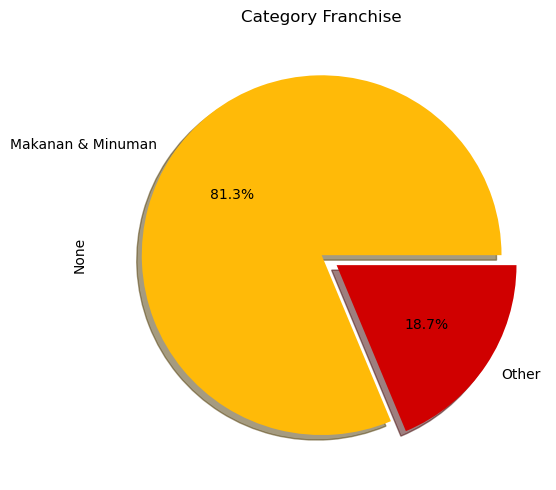

In [7]:
colors=['#ffba08','#d00000']
dfscrap2['Kat'] = dfscrap2['Kategori Franchise'].apply(setkfr)
plt.figure(figsize=(8, 5))
plt.title('Category Franchise')
t = dfscrap2.groupby('Kat').size().plot(autopct='%1.1f%%', kind = 'pie', shadow = True, explode = (0, 0.10),colors = colors)
t.spines[['right','top']].set_visible(False)
plt.tight_layout()

__Note :__
- Beberapa collecting dan cleaning data menggunakan excel, sehingga kami menggunakan dataframe `FR_FIX.csv` sebagai gabungan keduanya.

<a class="anchor" id="3">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Load Data 💾</h1></center>

In [8]:
df = pd.read_csv('FR_FIX.csv')

In [9]:
df.head()

,Nama Franchise,Modal Minimal (IDR),Berdiri Sejak,Jumlah Gerai,Omset per Bulan (IDR),Biaya Pengeluaran (IDR)
0,Bebek Murah,75000000,2022,6,250560000,222902400
1,Ayam Kremes Pramesti,120000000,2022,53,67500000,54485000
2,BURJOBAR,300000000,2022,1,57000000,31000000
3,Next Thai,49000000,2022,1,56550000,42751000
4,Negiya Bowl,49000000,2022,5,56000000,40000000


### Menambah Kolom Baru Berdasarkan Domain Knowledge
----

In [10]:
def add_calculated_columns(dataframe, current_year):
    
    dataframe['Usia Franchise'] = current_year - dataframe['Berdiri Sejak']
    dataframe['Net Profit Margin (%)'] = ((dataframe['Omset per Bulan (IDR)'] - dataframe['Biaya Pengeluaran (IDR)']) / dataframe['Omset per Bulan (IDR)']) * 100
    dataframe['Payback Period (Bulan)'] = dataframe['Modal Minimal (IDR)'] / (dataframe['Omset per Bulan (IDR)'] - dataframe['Biaya Pengeluaran (IDR)'])
   
    return dataframe

In [11]:
add_calculated_columns(df,2023)
df.head()

,Nama Franchise,Modal Minimal (IDR),Berdiri Sejak,Jumlah Gerai,Omset per Bulan (IDR),Biaya Pengeluaran (IDR),Usia Franchise,Net Profit Margin (%),Payback Period (Bulan)
0,Bebek Murah,75000000,2022,6,250560000,222902400,1,11.038314,2.711732
1,Ayam Kremes Pramesti,120000000,2022,53,67500000,54485000,1,19.281481,9.220131
2,BURJOBAR,300000000,2022,1,57000000,31000000,1,45.614035,11.538462
3,Next Thai,49000000,2022,1,56550000,42751000,1,24.401415,3.550982
4,Negiya Bowl,49000000,2022,5,56000000,40000000,1,28.571429,3.062500


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Nama Franchise           524 non-null    object 
 1   Modal Minimal (IDR)      524 non-null    int64  
 2   Berdiri Sejak            524 non-null    int64  
 3   Jumlah Gerai             524 non-null    int64  
 4   Omset per Bulan (IDR)    524 non-null    int64  
 5   Biaya Pengeluaran (IDR)  524 non-null    int64  
 6   Usia Franchise           524 non-null    int64  
 7   Net Profit Margin (%)    524 non-null    float64
 8   Payback Period (Bulan)   524 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 37.0+ KB


### Interpertasi
---
Variabel pada dataset terdiri dari 1 objek dan 8 numerik.

In [13]:
df.describe()

,Modal Minimal (IDR),Berdiri Sejak,Jumlah Gerai,Omset per Bulan (IDR),Biaya Pengeluaran (IDR),Usia Franchise,Net Profit Margin (%),Payback Period (Bulan)
count,5.240000e+02,524.000000,524.000000,5.240000e+02,5.240000e+02,524.000000,524.000000,524.000000
mean,4.526305e+07,2017.020992,89.250000,3.198062e+07,2.118413e+07,5.979008,37.999386,4.059901
std,9.828588e+07,4.427182,290.993039,4.235474e+07,4.685855e+07,4.427182,51.290390,10.218478
min,1.000000e+06,1994.000000,1.000000,6.700000e+05,2.000000e+05,1.000000,-706.451613,-0.947522
25%,5.150000e+06,2016.000000,5.000000,1.257500e+07,6.000000e+06,3.000000,25.544218,0.908288
50%,1.225000e+07,2018.000000,11.000000,1.950000e+07,1.133750e+07,5.000000,36.902763,1.895813
75%,4.000000e+07,2020.000000,50.000000,3.517500e+07,2.200000e+07,7.000000,56.150794,4.100791
max,1.200000e+09,2022.000000,2890.000000,4.100000e+08,8.300000e+08,29.000000,97.333333,200.000000


### Interpertasi
---
- Variabel `Berdiri Sejak` dan `Usia Franchise` memiliki `standar deviasi < mean` artinya sebaran dari variabel data yang kecil atau tidak adanya kesenjangan yang cukup besar.
- Sedangkan variabel lainnya memiliki `standar deviasi > mean` menandakan sebaran data besar.

### Cek Data Kosong
----

In [14]:
df.isnull().sum()/len(df)*100

Nama Franchise             0.0
Modal Minimal (IDR)        0.0
Berdiri Sejak              0.0
Jumlah Gerai               0.0
Omset per Bulan (IDR)      0.0
Biaya Pengeluaran (IDR)    0.0
Usia Franchise             0.0
Net Profit Margin (%)      0.0
Payback Period (Bulan)     0.0
dtype: float64

### Interpertasi
---
Tidak ada data yang kosong.

### Cek Duplikat Data
----

In [15]:
df.duplicated().sum()

0

### Interpertasi
---
Tidak ada data yang duplikat.

<a class="anchor" id="4">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Exploratory Data Analysis (EDA) 📊</h1></center>

### Cek Anomali dengan Boxplot
----

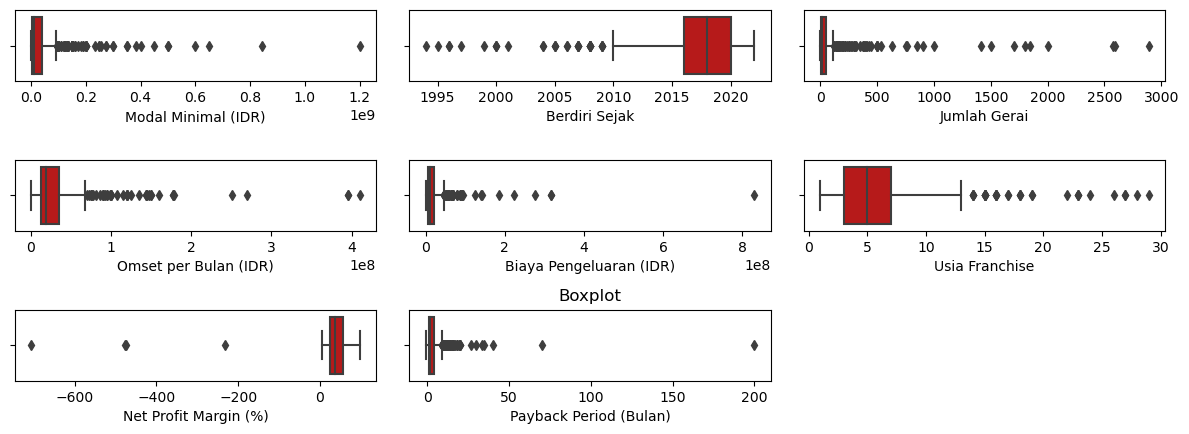

In [16]:
dfbox = df.select_dtypes('number')
fig = plt.figure(figsize = (12,10))

for i in range(len(dfbox.columns)):
    col = dfbox.columns[i]
    sub = fig.add_subplot(7,3,i+1)
    sns.boxplot(x=col, data=dfbox, color = '#d00000')

plt.title('Boxplot')
fig.tight_layout()
plt.show()

### Interpertasi
---
- Seluruh variabel pada dataset mengandung anomali.
- `Berdiri Sejak` dan `Net Profit Margin` memiliki anomali di bawah batas bawah, yang menandakan kemiringan kiri `(negative skewness)`.
- Sedangkan variabel lainnya memiliki anomali di atas batas atas, yang menandakan kemiringan kanan `(positive skewness)`.

### Rata-Rata Margin Keuntungan Bersih Sepanjang Waktu
----

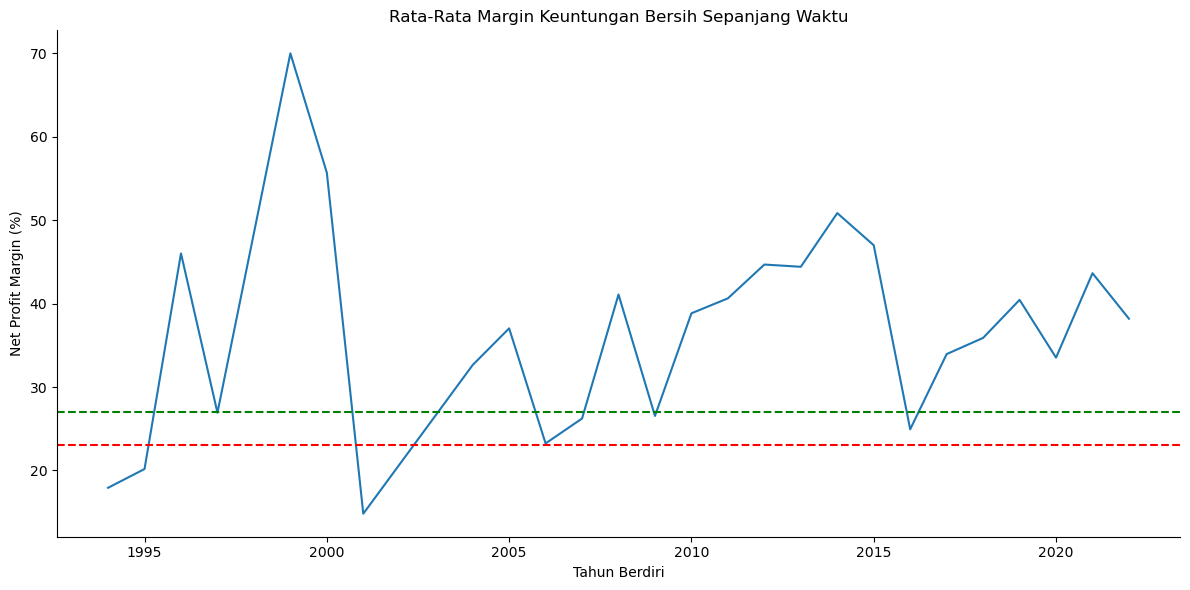

In [17]:
profit_margin_trend = df.groupby('Berdiri Sejak')['Net Profit Margin (%)'].mean().reset_index()
plt.figure(figsize=(12, 6))
t= sns.lineplot(x='Berdiri Sejak', y='Net Profit Margin (%)', data=profit_margin_trend,palette='#650021')
plt.xlabel('Tahun Berdiri')
plt.title('Rata-Rata Margin Keuntungan Bersih Sepanjang Waktu')
plt.axhline(y=23, color='r', linestyle='--', label="23% Resistance")
plt.axhline(y=27, color='g', linestyle='--', label="27% Resistance")
t.spines[['right','top']].set_visible(False)
plt.tight_layout();

### Insight
---
Tren rata-rata margin laba bersih dari tahun ke tahun menunjukkan fluktuasi, namun kita dapat mengamati tingkat resistensi pada kisaran `23%-27%`. Hal ini mengindikasikan bahwa kondisi saat ini dari industri Franchise makanan dan minuman di Indonesia masih cukup baik.

### 10 Franchises dengan Tingkat Pengembalian Tercepat
----

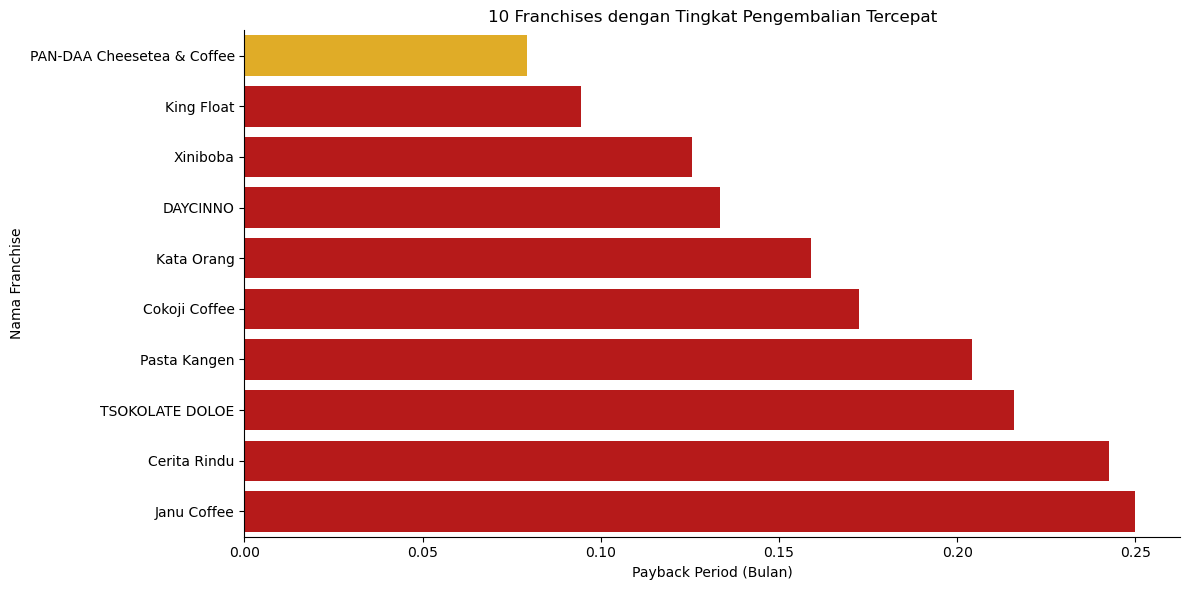

In [18]:
positive_payback = df[df['Payback Period (Bulan)'] > 0]
top_payback = positive_payback.nsmallest(10, 'Payback Period (Bulan)')
colors=['#ffba08','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000']
plt.figure(figsize=(12, 6))
plt.title('10 Franchises dengan Tingkat Pengembalian Tercepat')
t = sns.barplot(x='Payback Period (Bulan)', y='Nama Franchise', data=top_payback,palette=colors)
t.spines[['right','top']].set_visible(False)
plt.tight_layout();

### Insight
---
Salah satu faktor Franchise yang sehat adalah memiliki periode pengembalian investasi (payback period) secara singkat, bisa kita lihat Franchise `PAN-DAA Cheesetea & Coffee` memiliki periode tersingkat dengan kurun waktu `2.4 hari` dan `Janu Coffee` dengan lama pengembalian `1 minggu`.

### 10 Franchise dengan Performa Ekspansi Tertinggi
---

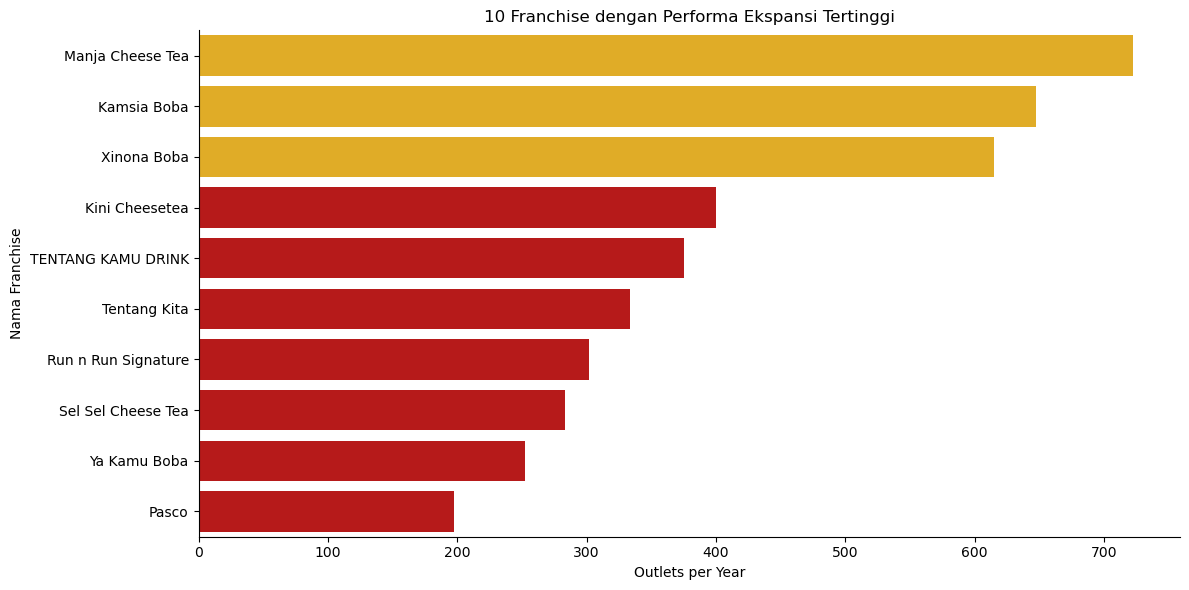

In [19]:
dfeda = df.copy()
dfeda['Outlets per Year'] = dfeda['Jumlah Gerai'] / dfeda['Usia Franchise']
colors=['#ffba08','#ffba08','#ffba08','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000']
top_scalability = dfeda.nlargest(10, 'Outlets per Year')
plt.figure(figsize=(12, 6))
plt.title('10 Franchise dengan Performa Ekspansi Tertinggi')
t = sns.barplot(x='Outlets per Year', y='Nama Franchise', data=top_scalability,palette=colors)
t.spines[['right','top']].set_visible(False)
plt.tight_layout();

### Insight
---
- Berdasarkan plot di atas, kita dapat lihat bahwa `Manja Cheese Tea` memiliki `700 gerai baru per tahun`. Potensi pertumbuhan sebuah Franchise yang berkembang cepat mungkin memiliki potensi pertumbuhan yang lebih tinggi di masa depan, terutama jika mereka beroperasi dalam industri yang sedang tumbuh seperti `Food and Beverage`.
- Franchise yang sukses dalam mengeksekusi strategi ekspansi mungkin akan lebih mampu menghadapi persaingan dan mengambil keuntungan dari peluang pasar.

### 10 Franchises dengan Tingkat Efisiensi Keuangan tertinggi
---

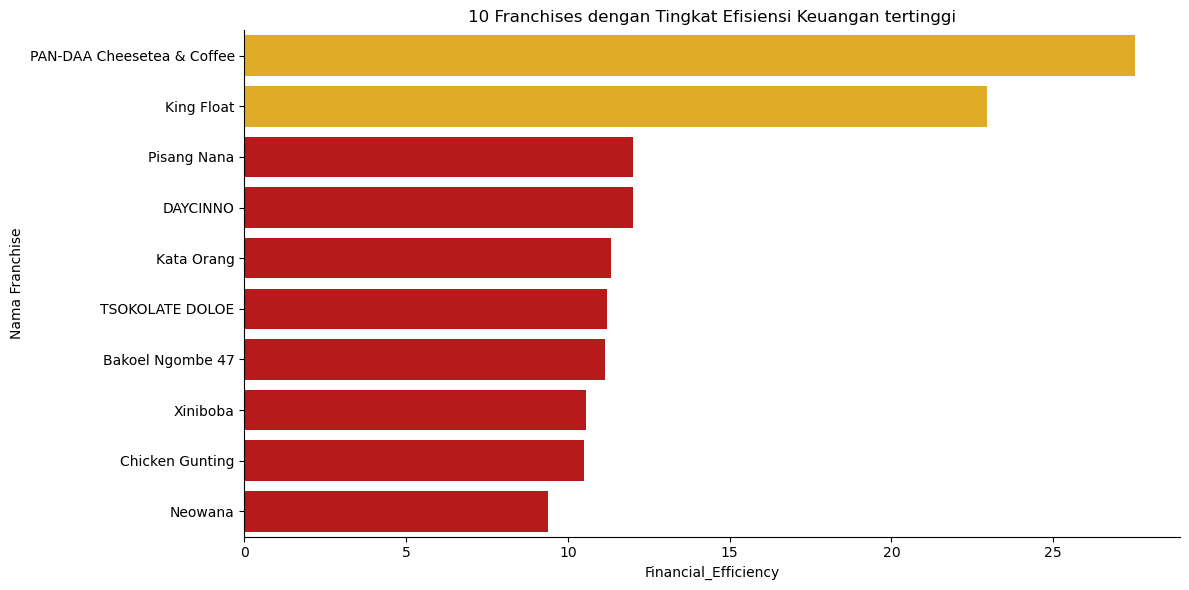

In [20]:
dfeda['Financial_Efficiency'] = dfeda['Omset per Bulan (IDR)'] / dfeda['Modal Minimal (IDR)']
colors=['#ffba08','#ffba08','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000']
top_efficiency = dfeda.nlargest(10, 'Financial_Efficiency')
plt.figure(figsize=(12, 6))
plt.title('10 Franchises dengan Tingkat Efisiensi Keuangan tertinggi')
t = sns.barplot(x='Financial_Efficiency', y='Nama Franchise', data=top_efficiency,palette=colors)
t.spines[['right','top']].set_visible(False)
plt.tight_layout();

### Insight
---
- Grafik batang ini menampilkan 10 Franchise dengan efisiensi keuangan tertinggi. Efisiensi keuangan dihitung dengan membagi Omset per Bulan dengan Modal Minimal Investasi.
- Kita bisa lihat `PAN-DAA Cheesetea & Coffee` memiliki `Efisiensi Keuangan Tertinggi sebesar 25`, Franchise ini menunjukkan efisiensi keuangan yang baik dimana mereka dapat menghasilkan omset yang relatif lebih tinggi terhadap investasi awal yang diperlukan.

<a class="anchor" id="5">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Preprocessing For Clustering Model 🛠️</h1></center>

### Cek Multikolinearitas dengan VIF Score
---

In [21]:
df2 = df.drop('Nama Franchise',axis=1)

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
vif['variable'] = df2.columns
vif

,VIF,variable
0,2.924415,Modal Minimal (IDR)
1,4.494345,Berdiri Sejak
2,1.014762,Jumlah Gerai
3,2.548117,Omset per Bulan (IDR)
4,3.071089,Biaya Pengeluaran (IDR)
5,2.847753,Usia Franchise
6,1.494093,Net Profit Margin (%)
7,2.125969,Payback Period (Bulan)


### Interpertasi
---
Karena nilai `VIF Score < 10`, maka dapat disimpulkan bahwa tidak ada multikolinearitas (hubungan) antar variabel bebas.

### ***Scalling*** Data dengan ***Robust Scaler***
---

In [22]:
scaler = RobustScaler()
dfstd = scaler.fit_transform(df2)
dfstd = pd.DataFrame(dfstd,columns=df2.columns)
dfstd.head()

,Modal Minimal (IDR),Berdiri Sejak,Jumlah Gerai,Omset per Bulan (IDR),Biaya Pengeluaran (IDR),Usia Franchise,Net Profit Margin (%),Payback Period (Bulan)
0,1.800574,1.0,-0.111111,10.223894,13.222806,-1.0,-0.845062,0.255574
1,3.091822,1.0,0.933333,2.123894,2.696719,-1.0,-0.575735,2.294225
2,8.256815,1.0,-0.222222,1.659292,1.228906,-1.0,0.284621,3.020404
3,1.054519,1.0,-0.222222,1.639381,1.963344,-1.0,-0.408453,0.518455
4,1.054519,1.0,-0.133333,1.615044,1.791406,-1.0,-0.272207,0.365446


### Interpertasi
---
Standarisasi data dilakukan menggunakan `Robust Scaler` karena terdapat anomali pada dataset.

### ***Principal Component Analysis***
---

In [23]:
pca = PCA(random_state=42)
pca.fit(dfstd)
pca.explained_variance_ratio_

array([5.43396168e-01, 2.16068096e-01, 1.35631623e-01, 4.14468284e-02,
       3.13245497e-02, 2.02318101e-02, 1.19009254e-02, 9.54031253e-36])

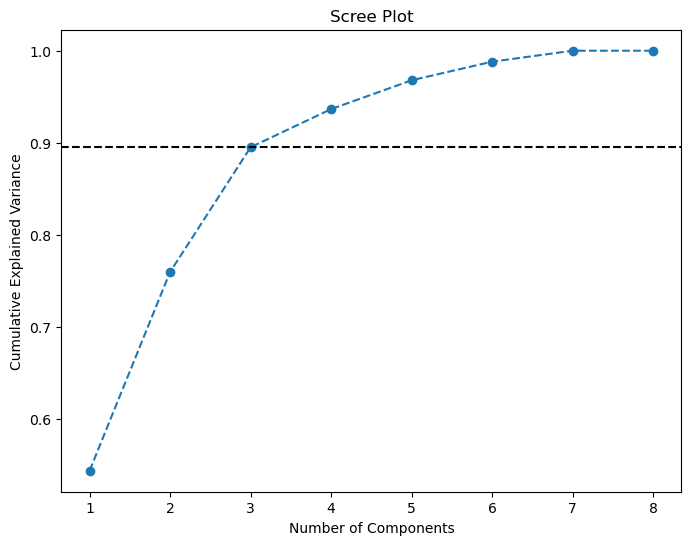

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 9), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y = 0.895, color = 'black', linestyle = '--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot');

### Interpertasi
---
Karena `Cumulative Explained Variance` menunjukkan threshold `89.5% pada komponen 3`, maka data direduksi menjadi 3 komponen.

In [25]:
pca = PCA(n_components=3, random_state=42)
pca.fit(dfstd)
df_pca = pca.transform(dfstd)

In [26]:
df_pca_comp = pd.DataFrame(
    data=pca.components_.round(4),
    columns=dfstd.columns.values,
    index=['Komponen '+str(1+i) for i in range(3)])
df_pca_comp

,Modal Minimal (IDR),Berdiri Sejak,Jumlah Gerai,Omset per Bulan (IDR),Biaya Pengeluaran (IDR),Usia Franchise,Net Profit Margin (%),Payback Period (Bulan)
Komponen 1,-0.0605,-0.0119,0.9957,-0.0284,-0.0346,0.0119,0.0032,-0.0506
Komponen 2,0.6293,-0.0193,0.0896,0.2574,0.4487,0.0193,-0.1063,0.5625
Komponen 3,0.0667,-0.0130,0.0032,-0.3299,-0.6665,0.0130,0.1791,0.6404


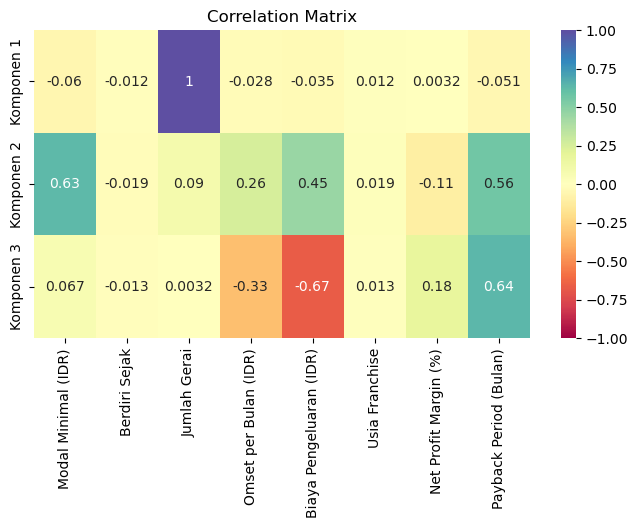

In [27]:
plt.figure(figsize=(8,4))
sns.heatmap(df_pca_comp, vmin=-1, vmax=1, cmap='Spectral', annot=True)
plt.title('Correlation Matrix');

### Interpertasi
---
- Komponen 1 mewakili `Jumlah Gerai`, maka disebut `Komponen Gerai`.
- Komponen 2 mewakili `Modal Minimal`, maka disebut `Komponen Modal`.
- Komponen 3 mewakili `Omset per Bulan`, `Biaya Pengeluaran`, `Net Profit Margin`, dan `Payback Period`, maka disebut `Komponen Performa`.
- Variabel `Berdiri Sejak` dan `Usia Franchise` memiliki kontribusi yang sedikit terhadap komponen. 

<a class="anchor" id="6">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Self Organized Maps (SOM) Model (Clustering) ⚙️</h1></center>

In [28]:
som = MiniSom(1, 2, df_pca.shape[1], sigma=0.5, learning_rate=0.5, random_seed=42)
som.train(df_pca, 100)
Result_som = [som.winner(x)[1] for x in df_pca]

In [29]:
df_copy = df.copy()
result_som = [som.winner(x)[1] for x in df_pca]
df_copy['Cluster'] = result_som

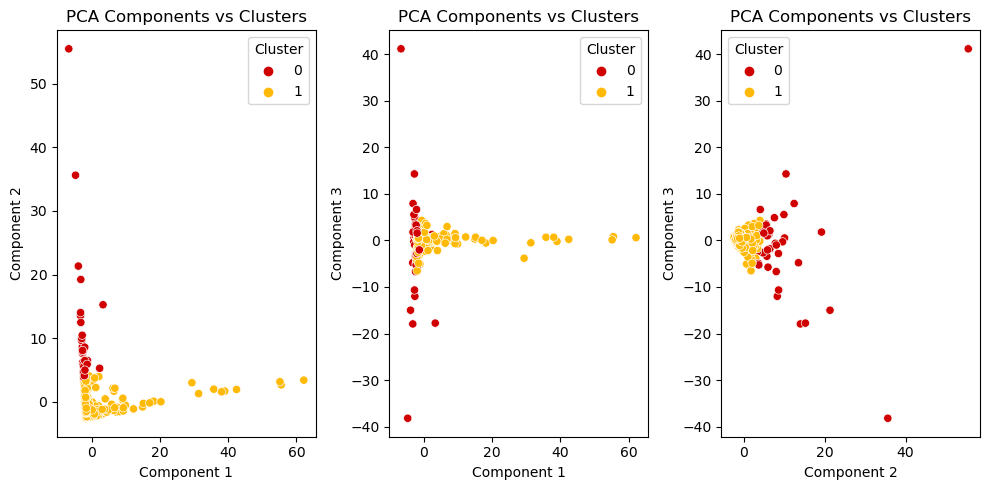

In [30]:
colors = ['#d00000','#ffba08']
fig = plt.figure(figsize = (10,5))
sub = fig.add_subplot(1,3,1)
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_copy['Cluster'], palette=colors)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Components vs Clusters')
plt.legend(title='Cluster')
sub = fig.add_subplot(1,3,2)
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 2], hue=df_copy['Cluster'], palette=colors)
plt.xlabel('Component 1')
plt.ylabel('Component 3')
plt.title('PCA Components vs Clusters')
plt.legend(title='Cluster')
sub = fig.add_subplot(1,3,3)
sns.scatterplot(x=df_pca[:, 1], y=df_pca[:, 2], hue=df_copy['Cluster'], palette=colors)
plt.xlabel('Component 2')
plt.ylabel('Component 3')
plt.title('PCA Components vs Clusters')
plt.legend(title='Cluster')
plt.tight_layout();

In [31]:
Counter(result_som)

Counter({0: 41, 1: 483})

### Interpertasi
---
- Plot klaster antara komponen 1 (Jumlah Gerai) dan komponen 2 (Modal Minimal) menandakan bahwa klaster 0 menunjukkan rendahnya `Jumlah Gerai` dengan tingginya `Modal Minimal`. Sedangkan klaster 1 menunjukkan tingginya `Jumlah Gerai` dengan rendahnya `Modal Minimal`.
- Plot klaster antara komponen 1 dan komponen 3 (Performa) menandakan bahwa klaster 0 menunjukkan rendahnya `Jumlah Gerai` dengan tingginya `Performa`. Sedangkan klaster 1 menunjukkan semakin tinggi `Jumlah Gerai` namun `Performa` cenderung konstan.

### Interpertasi
---
Klaster 0 terdiri dari 41 Franchise, sedangkan klaster 1 terdiri dari 483 Franchise.

In [32]:
sil2 = (silhouette_score(df_pca, result_som, random_state=42)).round(4)
dbi2 = (davies_bouldin_score(df_pca, result_som)).round(4)

cind = calc_c_index(df_pca, result_som).round(4)
print('Silhouette Index :',sil2)
print('Davies Bouldin Index :',dbi2)
print('Hubert & Levin C-Index :',cind)

Silhouette Index : 0.627
Davies Bouldin Index : 1.1626
Hubert & Levin C-Index : 0.4364


### Profiling Cluster
---

In [33]:
df_copy1 = df_copy.groupby('Cluster').mean().round(4).T
df_copy1.style.highlight_max(color = 'lightgreen', axis = 1)

Cluster,0,1
Modal Minimal (IDR),280543902.439000,25290968.944100
Berdiri Sejak,2015.780500,2017.126300
Jumlah Gerai,23.243900,94.853000
Omset per Bulan (IDR),115347463.414600,24903932.289900
Biaya Pengeluaran (IDR),97081723.146300,14741474.072500
Usia Franchise,7.219500,5.873700
Net Profit Margin (%),20.869300,39.453500
Payback Period (Bulan),17.477400,2.920900


### Interpertasi
---

Cluster 0:

- Modal Minimal (IDR): Rata-rata modal minimal yang diperlukan untuk memulai usaha ini adalah sebesar 280.543.902 IDR.
- Berdiri Sejak: Usaha dalam cluster ini rata-rata telah berdiri sejak tahun 2015.78.
- Jumlah Gerai: Rata-rata jumlah gerai dalam cluster ini adalah sekitar 23.
- Omset per Bulan (IDR): Rata-rata omset per bulan adalah sekitar 115.347.463 IDR.
- Biaya Pengeluaran (IDR): Rata-rata biaya pengeluaran dalam cluster ini adalah sekitar 97.081.723 IDR.
- Usia Franchise: Rata-rata usia franchise dalam cluster ini adalah 7.22 tahun.
- Net Profit Margin (%): Rata-rata net profit margin adalah sekitar 20.87%.
- Payback Period (Bulan): Rata-rata payback period atau waktu pengembalian modal investasi adalah sekitar 17.48 bulan.

Cluster 1:

- Modal Minimal (IDR): Rata-rata modal minimal yang diperlukan untuk memulai usaha ini adalah sebesar 25.290.968 IDR.
- Berdiri Sejak: Usaha dalam cluster ini rata-rata telah berdiri sejak tahun 2017.13.
- Jumlah Gerai: Rata-rata jumlah gerai dalam cluster ini adalah sekitar 95.
- Omset per Bulan (IDR): Rata-rata omset per bulan adalah sekitar 24.903.932 IDR.
- Biaya Pengeluaran (IDR): Rata-rata biaya pengeluaran dalam cluster ini adalah sekitar 14.741.474 IDR.
- Usia Franchise: Rata-rata usia franchise dalam cluster ini adalah 5.87 tahun.
- Net Profit Margin (%): Rata-rata net profit margin adalah sekitar 39.45%.
- Payback Period (Bulan): Rata-rata payback period atau waktu pengembalian modal investasi adalah sekitar 2.92 bulan.

> Klaster 0 memiliki karakteristik lebih lama berdiri, tingginya modal minimal yang diikuti dengan omset per bulan dan biaya pengeluaran yang tinggi, serta lamanya payback period, maka disebut `Franchise Tidak Sehat`.


> Klaster 1 memiliki karakteristik lebih baru berdiri dan jumlah gerai yang banyak dengan tingginya net profit margin, maka disebut `Franchise Sehat`.

<a class="anchor" id="7">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Preprocessing For Classification Model 🛠️</h1></center>

### ***Split Train Test***
---

In [34]:
df_c = dfstd.copy()
df_c['Cluster'] = result_som
X = df_c.drop(['Cluster'], axis =1)
y = df_c['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y, test_size = 0.3, random_state = 100)

### ***SMOTE***
---

In [35]:
smote = SMOTE()
X_train,y_train = smote.fit_resample(X_train,y_train)

### ***Feature Selection***
---

In [36]:
X_train_df_c = pd.DataFrame(data=X_train, columns=X_train.columns)

In [37]:
corr = X_train_df_c.corr(method = 'spearman')

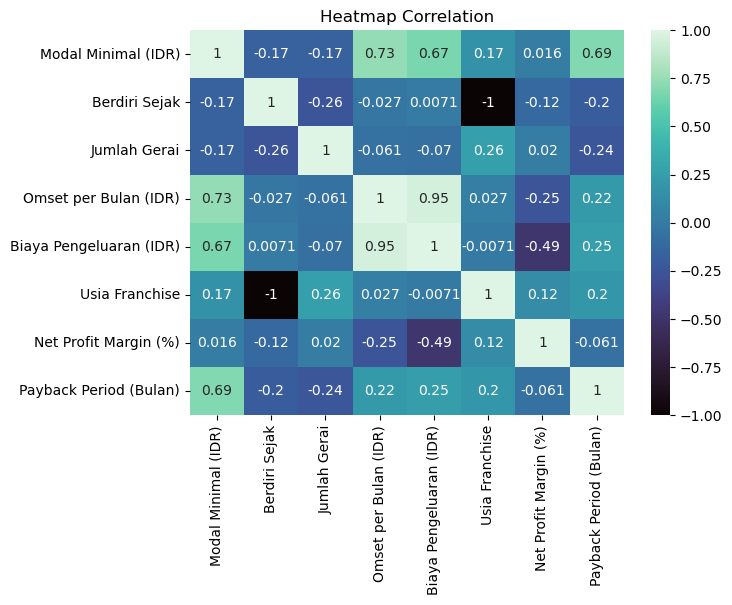

In [38]:
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True,cmap='mako')
plt.title('Heatmap Correlation')
plt.show()

In [39]:
var = []
drop = []
for x in X_train_df_c.columns:
  for y in X_train_df_c.columns:
    if x != y:
      if [y,x] not in var:
        corr, p_value = spearmanr(X_train_df_c[x], X_train_df_c[y])
        var.append([x, y])
        if (corr <= -0.8) | (corr >= 0.8):
          if p_value < 0.05:
            drop.append(y)

In [40]:
drop

['Usia Franchise', 'Biaya Pengeluaran (IDR)']

In [41]:
X_train_df_c = X_train_df_c.drop(drop, axis=1)

In [42]:
mutual_info_classif(X_train_df_c,
                    y_train,
                    random_state = 123)

array([0.56441245, 0.36574809, 0.30772961, 0.39704327, 0.12076376,
       0.26495111])

In [43]:
mutual_table = pd.DataFrame(mutual_info_classif(X_train_df_c,y_train,random_state = 123),
                            index = X_train_df_c.columns,
                            columns = ['mutual_info']).sort_values('mutual_info', ascending = False)

In [44]:
mutual_table

,mutual_info
Modal Minimal (IDR),0.564412
Omset per Bulan (IDR),0.397043
Berdiri Sejak,0.365748
Jumlah Gerai,0.307730
Payback Period (Bulan),0.264951
Net Profit Margin (%),0.120764


In [45]:
X_train_mt = mutual_table.iloc[0:6].index

In [46]:
X_train = X_train_df_c.loc[:, X_train_mt]

In [47]:
X_train.shape

(674, 6)

In [48]:
X_test = pd.DataFrame(data=X_test, columns=X_test.columns)

In [49]:
X_test = X_test.loc[:,list(X_train.columns)]

In [50]:
X_test.shape

(158, 6)

<a class="anchor" id="8">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Logistic Regression Model (Classification) ⚙️</h1></center>

In [51]:
LR= LogisticRegression()

### ***GridsearchCV Logistic Regression***
---

In [52]:
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.1, 1, 10,],
    'solver': ['newton-cg', 'liblinear', 'saga'],
    'max_iter': [50, 100],
 }

In [53]:
grid_search = GridSearchCV(LR, param_grid, cv=10, verbose=1)

In [54]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'max_iter': [50, 100],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['newton-cg', 'liblinear', 'saga']},
             verbose=1)

In [55]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'C': 1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.9925373134328359


### ***Logistic Regression Best Params***
---

In [66]:
LR= LogisticRegression(C = 1, max_iter = 50, penalty = 'l2', solver='newton-cg',random_state=123)  
LR.fit(X_train,y_train)

y_pred_LR = LR.predict(X_test)

In [67]:
report = classification_report(y_test, y_pred_LR)
print('Classification report:\n', report)

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.99      1.00      1.00       146

    accuracy                           0.99       158
   macro avg       1.00      0.96      0.98       158
weighted avg       0.99      0.99      0.99       158



In [68]:
LR.score(X_train,y_train),LR.score(X_test,y_test)

(0.9955489614243324, 0.9936708860759493)

### ***ROC Curve***
---

In [59]:
y_pred_proba = LR.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

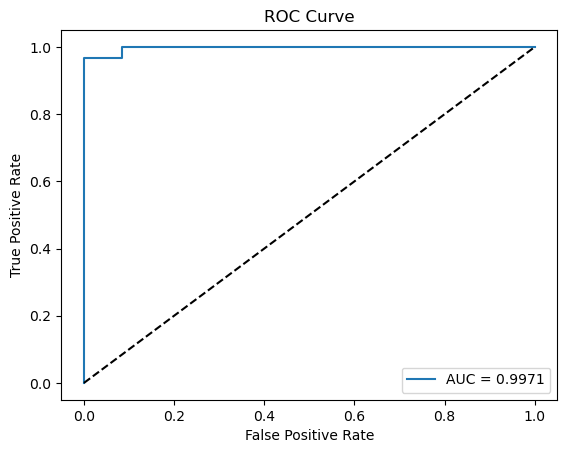

In [60]:
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend();

### Penjelasan
---
Dalam hal ini, model machine learning memiliki nilai AUC = 0.9966. Ini menunjukkan bahwa model sangat baik dalam membedakan antara kelas positif dan negatif. Semakin dekat nilai AUC dengan 1, maka semakin baik model dalam memprediksi kelas positif dan negatif secara akurat.

### ***Feature Importance***
---

Berdiri Sejak: 0.01040
Net Profit Margin (%): 1.09225
Jumlah Gerai: 1.30187
Modal Minimal (IDR): 1.99353
Payback Period (Bulan): 3.12217
Omset per Bulan (IDR): 3.87079


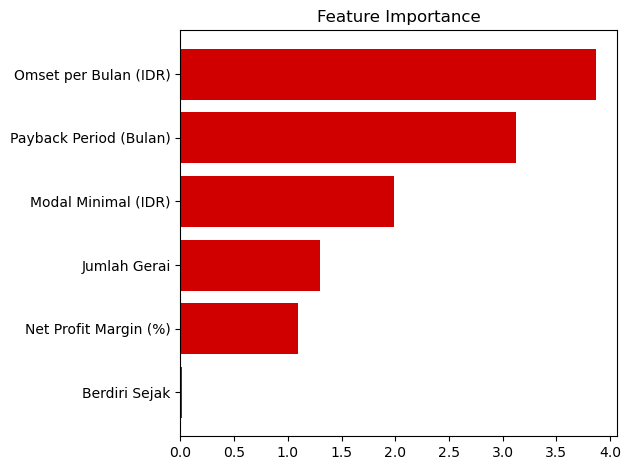

In [61]:
importance = LR.coef_[0]

feature_dict = {}

for i, v in enumerate(importance):
    feature_dict[X_train.columns[i]] = abs(v)

sorted_feature_dict = dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=False))

for k, v in sorted_feature_dict.items():
    print(f"{k}: {v:.5f}")

colors=['#d00000','#d00000','#d00000','#d00000','#d00000','#d00000','#d00000','#ffba08']
t = plt.barh(range(len(importance)), [sorted_feature_dict[k] for k in sorted_feature_dict.keys()], color=colors)
plt.yticks(range(len(importance)), [k for k in sorted_feature_dict.keys()])

plt.title('Feature Importance')
plt.tight_layout()

### Penjelasan
---
- Berdasarkan fitur importance yang diberikan, fitur yang paling berpengaruh terhadap prediksi adalah Omset Per Bulan dengan nilai fitur importance sebesar 5.1 Fitur kedua yang paling berpengaruh adalah Payback periode dengan nilai fitur importance sebesar 4.07.

- Fitur importance yang lebih kecil dari 1 seperti berdiri sejak, menunjukkan bahwa fitur tersebut memiliki pengaruh yang relatif kecil terhadap prediksi yang dihasilkan oleh model.

<a class="anchor" id="9">
<center><h1 style="font-family: Trebuchet MS; padding: 20px; font-size: 25px; color: #ffe45e; text-align: center; line-height: 0.75;background-color: #d00000">Summary 📖</h1></center>

**Kami berhasil mengelompokkan Franchise berdasarkan performa, yaitu Franchise dengan performa Sehat dan Tidak Sehat.**

Dengan ciri-ciri:

| Franchise Sehat | Franchise Tidak Sehat |
|-------------|-------------|
| Jumlah Gerai banyak | Modal Minimal tinggi | 
| Net Profit Margin  tinggi | Omset per bulan tinggi | 
| Payback period singkat | Biaya pengeluaran  tinggi |
| Usia franchise lebih muda | Usia franchise lebih tua |
    
**Kami juga berhasil menentukan faktor-faktor yang paling berpengaruh dalam menentukan kondisi sebuah franchise.**

Faktor Paling berpengaruh yaitu :

    1. Omset per Bulan
    2. Payback Period
    3. Modal Minimal
    4. Jumlah Gerai
    5. Net Profit Margin
    6. Berdiri Sejak
    
Berdasarkan penelitian dan proses Machine Learning yang sudah dilakukan pada dataset ini, dapat disimpulkan bahwa model terbaik dalam melakukan prediksi kondisi sebuah Franchise yaitu model Logistic Regression dengan tingkat keakuratan sebesar __99%__.